### Benchmarking rational interpolation over finite fields 

..using van der Hoeven and Lecerf algorihm with the **known bounds** on the partial degrees and number of terms in the interpolant.

In [2]:
# include the ExactSparseInterpolations package from the local dir 
include("../src/ExactSparseInterpolations.jl");

In [3]:
using Nemo
using BenchmarkTools
using Primes
using DataFrames
using LinearAlgebra
using Plots

#### Part 0 - what hides behind $M(n)$

Here, we benchmark the multiplication of polynomials over finite fields. We want to verify that the complexity of multiplication $M(n)$ grows as $nlog^k(n)$ for some small positive $k$.

The multiplication routine itself is a call to a compiled Flint library.


In [4]:
_base = 2;

In [5]:
# from nanoseconds to seconds
sround(t) = round(t, digits=4);
ns2s(t) = sround(t / 1e9);

In [6]:
# Benchmark the multiplication of polynomials
# on the range of degrees _base ^ n, for n in ns
function benchmark_mulitiply(R, ns)
    times = (
        total=Float64[],
    )
    K = base_ring(R)
    x = gen(R)
    randpoly(degree_range) = rand(R, degree_range)
    for i in ns
        n = floor(Int, _base^i)
        f1 = randpoly(n:n)
        f2 = randpoly(n:n)
        @assert degree(f1) == _base^i
        @assert degree(f2) == _base^i
        bench = @benchmarkable *($f1, $f2) samples=3
        result = mean(run(bench)).time
        push!(times.total, ns2s(result))
    end
    times
end

benchmark_mulitiply (generic function with 1 method)

In [12]:
Zp = GF(2^30*3 + 1)
R_u, x_u = PolynomialRing(Zp, "x")
range_u = 14:22
times_u = benchmark_mulitiply(R_u, range_u)

(total = [0.0063, 0.0118, 0.03, 0.0615, 0.1351, 0.2908, 0.7659, 1.5685, 3.2669],)

In [18]:
df_u = DataFrame(
    degree=["$_base^$i" for i in range_u], 
    total=times_u.total
)
df_u

Row,degree,total
,String,Float64
1,2^14,0.0063
2,2^15,0.0118
3,2^16,0.03
4,2^17,0.0615
5,2^18,0.1351
6,2^19,0.2908
7,2^20,0.7659
8,2^21,1.5685
9,2^22,3.2669


The factor $M(n+1)/M(n)$ is more or less constant, and roughly equals $2 + \frac{log(n) + k}{log^2(n)}$.

So the multiplication is likely to have $nlog^k(n)$ complexity.

#### Part 1 - fixed degree

As the number of terms $T$ grows, the runtime grows as $M(T)\log T$, or $T\log^kT$. **Is it true?**

We benchmark on a sequence of rational functions $f_i$ for $i = 1,2,\ldots,$.

- the number of terms both in the numerator and denominator of $f_i$ is $1.5^i$;
- the total degree of $f_i$ is constant and equals $2^{7}$;

In this experiment, the ground field is $Z/Z_{3*2^{30} + 1}$.

In [33]:
_base = 1.5

1.5

In [35]:
# Benchmark the interpolation of a rational function
# on the range of terms _base ^ n, for n in ns
function benchmark_vdhl_nterms(R, ns)
    times = (
        total=Float64[],
        cauchy=Float64[],
        pointsmanip=Float64[],
        evaluate=Float64[],
        benortiwari=Float64[],
    )
    K = base_ring(R)
    xs = gens(R)
    randpoly(term_range, exp_range) = rand(R, term_range, exp_range)
    D = 2^7
    Dav = div(D, length(xs)) 
    for i in ns
        n = floor(Int, _base^i)
        f1 = xs[1]^D + randpoly(n-1:n-1, 0:Dav)
        f2 = xs[1]^D + randpoly(n-1:n-1, 0:Dav)
        @assert (length(f1) - n) / n < 0.01
        @assert (length(f2) - n) / n < 0.01
        @assert total_degree(f1) == D
        @assert total_degree(f2) == D
        func = f1 // f2
        blackbox = ExactSparseInterpolations.Blackbox(func)
        info = ExactSparseInterpolations.getboundsinfo(func)
        vdhl = ExactSparseInterpolations.FasterVanDerHoevenLecerf(R, info)
        
        P, Q = ExactSparseInterpolations.interpolate!(vdhl, blackbox)
        @assert P//Q == func
        
        bench = @benchmarkable ExactSparseInterpolations.interpolate!($vdhl, $blackbox) samples=3
        result = mean(run(bench)).time
        push!(times.total, ns2s(result))
        internaltimes = ExactSparseInterpolations._runtime_vdhl_dump()
        push!(times.cauchy, sround(internaltimes.cauchy))
        push!(times.pointsmanip, sround(internaltimes.pointsmanip))
        push!(times.evaluate, sround(internaltimes.evaluate))
        push!(times.benortiwari, sround(internaltimes.benortiwari))
    end
    times
end

benchmark_vdhl_nterms (generic function with 1 method)

In [36]:
Zp = GF(2^30*3 + 1)
R_zp, x_zp = PolynomialRing(Zp, ["x","y","z"])
range_zp = 3:10
times_zp = benchmark_vdhl_nterms(R_zp, range_zp)

(total = [0.0208, 0.0421, 0.0821, 0.1102, 0.2124, 0.3488, 0.5756, 0.8186], cauchy = [0.0134, 0.0325, 0.039, 0.0641, 0.1048, 0.2658, 0.2657, 0.3977], pointsmanip = [0.0011, 0.0022, 0.0031, 0.0051, 0.0077, 0.0104, 0.0147, 0.0217], evaluate = [0.0072, 0.0183, 0.0331, 0.0448, 0.0846, 0.1134, 0.252, 0.3379], benortiwari = [0.0004, 0.0005, 0.0012, 0.0014, 0.0029, 0.0035, 0.0055, 0.0091])

In [38]:
df_zp = DataFrame(
    nterms=["$_base^$i" for i in range_zp], 
    total=times_zp.total,
    cauchy=times_zp.cauchy,
    points_manip=times_zp.pointsmanip,
    evaluate=times_zp.evaluate,
    benortiwari=times_zp.benortiwari,
)
df_zp

Row,nterms,total,cauchy,points_manip,evaluate,benortiwari
,String,Float64,Float64,Float64,Float64,Float64
1,1.5^3,0.0208,0.0134,0.0011,0.0072,0.0004
2,1.5^4,0.0421,0.0325,0.0022,0.0183,0.0005
3,1.5^5,0.0821,0.039,0.0031,0.0331,0.0012
4,1.5^6,0.1102,0.0641,0.0051,0.0448,0.0014
5,1.5^7,0.2124,0.1048,0.0077,0.0846,0.0029
6,1.5^8,0.3488,0.2658,0.0104,0.1134,0.0035
7,1.5^9,0.5756,0.2657,0.0147,0.252,0.0055
8,1.5^10,0.8186,0.3977,0.0217,0.3379,0.0091


Fitting $f(n)$ to experimental data,

$$
f(n) = a\cdot nlog(n)^2 + b\cdot nlog(n) + c\cdot n + d\cdot log(n)
$$

In [44]:
# Solve Ax = b
literal_range = _base .^ range_zp
A = hcat(
    [n*log2(n)^2 for n in literal_range],
    [n*log2(n) for n in literal_range],
    [n for n in literal_range],
    [log2(n) for n in literal_range],
)
# add a small random term as a regularization
b = (times_zp.total - times_zp.evaluate) .+ 0.01
a, b, c, d = A \ b

4-element Vector{Float64}:
  0.0008337100371275775
 -0.015464141737641319
  0.07963640519579082
 -0.09086632791647017

In [45]:
f(n) = a*n*log2(n)^2 + b*n*log2(n) + c*n + d*log2(n)

f (generic function with 1 method)

In [46]:
df_zp2 = DataFrame(
    nterms=["$_base^$i" for i in range_zp], 
    total=times_zp.total - times_zp.evaluate,
    estimation=[f(n) for n in _base .^ range_zp],
)
df_zp2

Row,nterms,total,estimation
,String,Float64,Float64
1,1.5^3,0.0136,0.0263879
2,1.5^4,0.0238,0.030473
3,1.5^5,0.049,0.0496674
4,1.5^6,0.0654,0.086937
5,1.5^7,0.1278,0.145519
6,1.5^8,0.2354,0.228996
7,1.5^9,0.3236,0.341639
8,1.5^10,0.4807,0.489423


Assessing the estimation for the inputs with higher number of terms

In [47]:
range_zp_2 = 3:14
times_zp_2 = benchmark_vdhl_nterms(R_zp, range_zp_2)

(total = [0.0271, 0.0603, 0.0505, 0.1239, 0.1479, 0.3785, 0.5367, 0.7368, 1.2574, 2.2437, 4.1086, 7.6181], cauchy = [0.0147, 0.0292, 0.0263, 0.0672, 0.0786, 0.2131, 0.274, 0.3715, 0.596, 1.0977, 1.6974, 2.6469], pointsmanip = [0.0014, 0.0025, 0.0026, 0.0049, 0.0065, 0.0106, 0.0163, 0.0209, 0.0314, 0.0473, 0.0741, 0.1199], evaluate = [0.0091, 0.0212, 0.0216, 0.0536, 0.0682, 0.1958, 0.2173, 0.3457, 0.6443, 1.1312, 2.2951, 5.0488], benortiwari = [0.0004, 0.0007, 0.001, 0.0013, 0.0019, 0.0037, 0.0061, 0.0098, 0.0137, 0.0276, 0.0552, 0.1098])

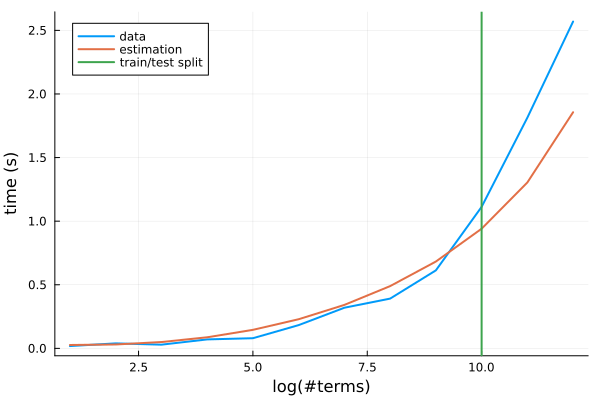

In [48]:
plot(times_zp_2.total - times_zp_2.evaluate, label="data", linewidth=2)
plot!(map(f, _base .^ range_zp_2), label="estimation", linewidth=2)
plot!([10.0], seriestype="vline", label="train/test split", linewidth=2)
xlabel!("log(#terms)")
ylabel!("time (s)")

In [49]:
df_zp2_2 = DataFrame(
    nterms=["$_base^$i" for i in range_zp_2], 
    total=times_zp_2.total - times_zp_2.evaluate,
    estimation=[f(n) for n in _base .^ range_zp_2],
)
df_zp2_2

Row,nterms,total,estimation
,String,Float64,Float64
1,1.5^3,0.018,0.0263879
2,1.5^4,0.0391,0.030473
3,1.5^5,0.0289,0.0496674
4,1.5^6,0.0703,0.086937
5,1.5^7,0.0797,0.145519
6,1.5^8,0.1827,0.228996
7,1.5^9,0.3194,0.341639
8,1.5^10,0.3911,0.489423
9,1.5^11,0.6131,0.682493
